<a href="https://colab.research.google.com/github/Dinesh-Adhithya-H/sports-analytics/blob/master/Xg_model_fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
from google.colab import files
src = list(files.upload().values())[0]
open('FCPython.py','wb').write(src)
from FCPython import createPitch

Saving FCPython.py to FCPython (1).py


In [53]:
with open("/content/drive/My Drive/Wyscout/events/events_England.json") as file:
  data=pd.read_json(file)

In [54]:
shots=data[data.subEventName=="Shot"]

In [55]:
shots_model=pd.DataFrame(columns=["Goal","X","Y","Angle"])

In [56]:
for i,shot in shots.iterrows():
  header=0
  for shottags in shot["tags"]:
    if shottags["id"]==403:
      header=1
  if not(header):
    shots_model.at[i,"X"]=100-shot["positions"][0]["x"]
    shots_model.at[i,"Y"]=shot["positions"][0]["y"]
    shots_model.at[i,"C"]=abs(shot["positions"][0]["y"]-50)
    x=shots_model.at[i,"X"]*105/100
    y=shots_model.at[i,"C"]*65/100
    shots_model.at[i,"Distance"]=np.sqrt(x**2+y**2)
    a=np.arctan(7.32*x/(x**2+y**2-(7.32/2)**2))
    if a<0:
      a=np.pi+a
      shots_model.at[i,"Angle"]=a
    else:
      shots_model.at[i,"Angle"]=a
    shots_model.at[i,"Goal"]="miss"
    for shottags in shot["tags"]:
      if shottags["id"]==101:
        shots_model.at[i,"Goal"]="goal"

In [57]:
shots_model.head()

,Goal,X,Y,Angle,C,Distance
46,goal,12,41,0.474451,9.0,13.891814
62,miss,15,52,0.453823,2.0,15.803560
128,miss,19,33,0.280597,17.0,22.805811
249,miss,25,30,0.22368,20.0,29.292704
394,miss,10,39,0.479051,11.0,12.703248


In [58]:
shots_model.dropna()

,Goal,X,Y,Angle,C,Distance
46,goal,12,41,0.474451,9.0,13.891814
62,miss,15,52,0.453823,2.0,15.803560
128,miss,19,33,0.280597,17.0,22.805811
249,miss,25,30,0.22368,20.0,29.292704
394,miss,10,39,0.479051,11.0,12.703248
...,...,...,...,...,...,...
642939,miss,14,40,0.41392,10.0,16.072959
642945,miss,28,45,0.244789,5.0,29.579089
643023,goal,14,33,0.319916,17.0,18.390011
643051,miss,12,62,0.420593,12.0,14.818907


In [59]:
len(shots_model[shots_model['Goal'] == 'miss']),len(shots_model[shots_model['Goal'] == 'goal'])

(6398, 736)

In [60]:
non_goal=shots_model[shots_model["Goal"]=="miss"]
goal=shots_model[shots_model["Goal"]=="goal"]
n_goal=non_goal.iloc[:len(shots_model[shots_model['Goal'] == 'goal']),:]
shots_data=pd.DataFrame()
shots_data=pd.concat([goal,n_goal])

In [61]:
len(n_goal),len(goal)

(736, 736)

In [62]:
shots_data.head()

,Goal,X,Y,Angle,C,Distance
46,goal,12,41,0.474451,9.0,13.891814
554,goal,6,54,0.948906,4.0,6.815424
898,goal,8,50,0.821821,0.0,8.400000
1570,goal,6,63,0.441023,13.0,10.540043
2982,goal,11,55,0.574628,5.0,11.998542


In [63]:
from sklearn.utils import shuffle
shots_data = shuffle(shots_data)

In [64]:
max(list(shots_model["X"])),max(list(shots_model["Y"])),min(list(shots_model["X"])),min(list(shots_model["Y"]))

(59, 99, 0, 7)

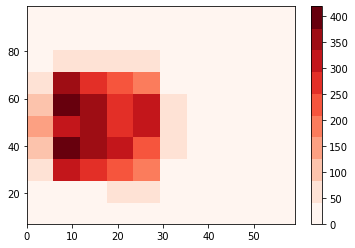

In [65]:
plt.hist2d(list(shots_model["X"]),list(shots_model["Y"]),bins=10,cmap=plt.cm.get_cmap('Reds', 10))
plt.ylim(7,99)
plt.xlim(0,59)
plt.colorbar()
plt.show()

In [66]:
shots_data.drop(axis=1,columns=["C"])

,Goal,X,Y,Angle,Distance
45210,miss,23,60,0.281166,25.009448
566841,goal,8,56,0.704251,9.261209
63929,miss,31,29,0.190974,35.296246
476657,goal,6,67,0.3013,12.719768
3973,miss,19,30,0.257911,23.811814
...,...,...,...,...,...
315988,goal,10,45,0.621073,10.991474
320126,goal,4,52,1.38012,4.396590
59531,miss,3,28,0.114208,14.642831
394431,goal,13,54,0.507489,13.895413


In [67]:
from sklearn.model_selection import train_test_split
x=shots_data[["X","Y","Distance","Angle"]]
y=shots_data["Goal"]
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [68]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=5)

In [69]:
knn.fit(x_train,y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [70]:
knn.score(x_test,y_test)

0.6847826086956522

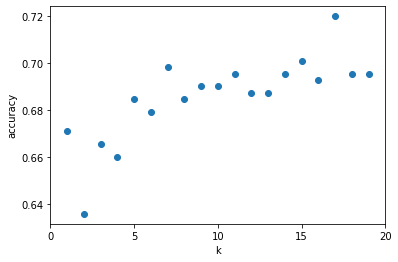

In [71]:
k_range=range(1,20)
scores=[]
for k in k_range:
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    scores.append(knn.score(x_test,y_test))
plt.figure()
plt.xlabel("k")
plt.ylabel("accuracy")
plt.scatter(k_range,scores)
plt.xticks([0,5,10,15,20])
plt.show()

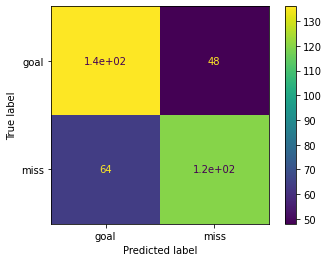

In [81]:
plot_confusion_matrix(knn,x_test,y_test)
plt.show()

In [72]:
from sklearn.linear_model import LogisticRegression

In [73]:
clf=LogisticRegression().fit(x_train,y_train)

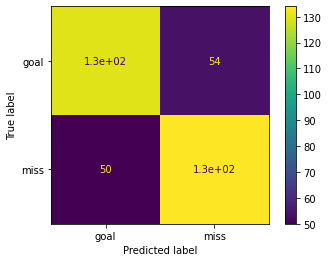

In [74]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,x_test,y_test)
plt.show()

In [75]:
print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(clf.score(x_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(clf.score(x_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.73
Accuracy of Logistic regression classifier on test set: 0.72


In [76]:
from sklearn.svm import SVC
this_c=1.0
clf=SVC(kernel="linear",C=this_c).fit(x_train,y_train)

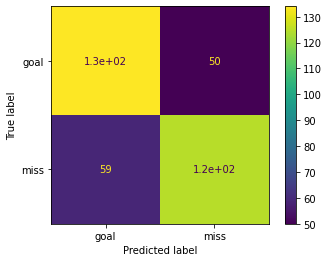

In [77]:
plot_confusion_matrix(clf,x_test,y_test)
plt.show()

In [78]:
print("accuracy of test class",clf.score(x_test,y_test))
print("accuracy of train class",clf.score(x_train,y_train))

accuracy of test class 0.7038043478260869
accuracy of train class 0.7445652173913043


In [79]:
from sklearn.tree import DecisionTreeClassifier
clf1=DecisionTreeClassifier(max_depth=3).fit(x_train,y_train)
print("accuracy of test class",clf1.score(x_test,y_test))
print("accuracy of train class",clf1.score(x_train,y_train))

accuracy of test class 0.7065217391304348
accuracy of train class 0.7490942028985508


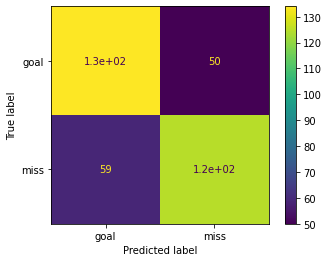

In [80]:
plot_confusion_matrix(clf,x_test,y_test)
plt.show()

In [85]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
model = Pipeline([('poly', PolynomialFeatures(degree=3)),('linear', LinearRegression(fit_intercept=False))])
y_train_=[]
for i in  y_train:
  if i=="miss":
    y_train_.append(0)
  else:
    y_train_.append(1)
model = model.fit(x_train,y_train_)

In [86]:
y_test_=[]
for i in  y_test:
  if i=="miss":
    y_test_.append(0)
  else:
    y_test_.append(1)

In [89]:
model.score(x_test,y_test_)

0.09776415577208096

In [94]:
from sklearn.metrics import accuracy_score
np.sum(model.predict(x_test)-y_test_)

0.5856137391144784